In [8]:
import lusid
import lusid.models as models
import os
from msrest.authentication import BasicTokenAuthentication

api_url = os.getenv("FBN_LUSID_API_URL")
api_token = {"access_token": os.environ["ACCESS_TOKEN"]}
credentials = BasicTokenAuthentication(api_token)
client = lusid.LUSIDAPI(credentials, api_url)

In [9]:
# create instruments

instruments = [
    {"Figi": "BBG000C6K6G9", "Name": "VODAFONE GROUP PLC"},
    {"Figi": "BBG000C04D57", "Name": "BARCLAYS PLC"},
    {"Figi": "BBG000FV67Q4", "Name": "NATIONAL GRID PLC"},
    {"Figi": "BBG000BF0KW3", "Name": "SAINSBURY (J) PLC"},
    {"Figi": "BBG000BF4KL1", "Name": "TAYLOR WIMPEY PLC"}
]

figis_to_create = { i["Figi"]:models.UpsertInstrumentRequest(i["Name"], {"Figi": i["Figi"]}) for i in instruments }

upsert_response = client.upsert_instruments(figis_to_create)

if len(upsert_response.failed) != 0:
    raise Exception(upsert_response.failed)

ids = client.get_instruments("Figi", [i["Figi"] for i in instruments])

instrument_ids = [i.lusid_instrument_id for i in ids.values.values()]

In [10]:
import uuid
from datetime import datetime
import pytz
from collections import namedtuple

def build_transaction(trade_spec):
    return models.TransactionRequest(
        transaction_id=str(uuid.uuid4()),
        type="StockIn",
        instrument_uid=trade_spec.id,
        transaction_date=trade_spec.trade_date,
        settlement_date=trade_spec.trade_date,
        units=100,
        transaction_price=models.TransactionPrice(trade_spec.price),
        total_consideration=models.CurrencyAndAmount(100 * trade_spec.price, "GBP"),
        source="Client"
    )

scope = "finbourne"
guid = str(uuid.uuid4())
effective_date = datetime(2018, 1, 1, tzinfo=pytz.utc)

request = models.CreateTransactionPortfolioRequest(
    "portfolio-{0}".format(guid),
    "id-{0}".format(guid),
    base_currency="GBP",
    created=effective_date
)

#   create the portfolio
result = client.create_portfolio(scope, request)

assert(result.id.code == request.code)

portfolio_id = result.id.code

TransactionSpec = namedtuple('TransactionSpec', 'id price trade_date')
transaction_specs = [
    TransactionSpec(instrument_ids[0], 101, effective_date),
    TransactionSpec(instrument_ids[1], 102, effective_date),
    TransactionSpec(instrument_ids[2], 103, effective_date)
]
transaction_specs.sort(key=lambda ts: ts.id)

new_transactions = list(map(build_transaction, transaction_specs))

#   add initial batch of trades
add_transactions_result = client.upsert_transactions(scope, portfolio_id, new_transactions)

In [11]:
try:
    analytic_store = client.get_analytic_store(
        scope,
        effective_date.year,
        effective_date.month,
        effective_date.day
    )
except Exception as e:
    analytic_store_request = models.CreateAnalyticStoreRequest(scope, effective_date)
    client.create_analytic_store(analytic_store_request)

prices = [
    models.InstrumentAnalytic(instrument_ids[0], 100),
    models.InstrumentAnalytic(instrument_ids[1], 200),
    models.InstrumentAnalytic(instrument_ids[2], 300)
]

#   add prices
prices_result = client.set_analytics(scope, effective_date.year, effective_date.month, effective_date.day, prices)

In [12]:
aggregation_request = models.AggregationRequest(
    recipe_id=models.ResourceId(scope, "default"),
    metrics=[
        models.AggregateSpec("Holding/default/PV", "Proportion"),
        models.AggregateSpec("Holding/default/PV", "Sum")
    ],
    group_by=["Security/default/CommonName"],
    effective_at=effective_date
)

#   do the aggregation
aggregation = client.get_aggregation_by_portfolio(scope, portfolio_id, aggregation_request)

In [13]:
for item in aggregation.data:
            print("\t{}\t{}\t{}".format(item["Security/default/CommonName"], item["Holding/default/PV%"], item["Holding/default/PV"]))

	SAINSBURY (J) PLC	0.3333333333333333	20000.0
	VODAFONE GROUP PLC	0.5	30000.0
	TAYLOR WIMPEY PLC	0.16666666666666666	10000.0


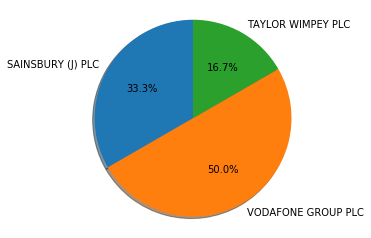

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

labels = []
values = []
for item in aggregation.data:
    labels.append(item["Security/default/CommonName"])
    values.append(item["Holding/default/PV%"] * 100)
    
fig1, ax1 = plt.subplots()
ax1.pie(values, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()